<div class="alert alert-info">

Launch in Binder     [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/esowc/UNSEEN-open/master?filepath=doc%2FNotebooks%2Fexamples%2FCalifornia_Fires.ipynb)

<!-- Or launch an [Rstudio instance](https://mybinder.org/v2/gh/esowc/UNSEEN-open/master?urlpath=rstudio?filepath=doc%2Fexamples%2FCalifornia_Fires.ipynb)
 -->
</div>

# California fires

In August 2020 in California, wildfires have burned more than [a million acres of land](https://edition.cnn.com/2020/10/06/us/gigafire-california-august-complex-trnd/index.html). 
This years' fire season was also unique in the number of houses destroyed. 

Here we retrieve average august temperatures over California within ERA5 1979-2020 and show anomalous August 2020 was. 
![California Temperature August 2020](../../../graphs/California_anomaly.png)


We furthermore create an UNSEEN ensemble and show that these kind of fire seasons can be expected to occur more often in our present climate since we find a clear trend in temperature extremes over the last decades.  

### Retrieve data

<div class="alert alert-info">

Note
    
In this notebook you cannot use the python functions under Retrieve and Preprocess (they are here only for documentation on the entire workflow, see [retrieve](../1.Download/1.Retrieve.ipynb) if you want to download your own dataset. The resulting preprocessed dataset is provided so you can perform statistical analysis on the dataset and rerun the evaluation and examples provided.
    
</div>

The main functions to retrieve all forecasts (SEAS5) and reanalysis (ERA5) are `retrieve_SEAS5` and `retrieve_ERA5`. We want to download 2m temperature for August over California. By default, the hindcast years of 1981-2016 are downloaded for SEAS5. We include the years 1981-2020. The folder indicates where the files will be stored, in this case outside of the UNSEEN-open repository, in a 'California_example' directory. For more explanation, see [retrieve](../1.Download/1.Retrieve.ipynb).

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../../'))
os.chdir(os.path.abspath('../../../'))

import src.cdsretrieve as retrieve
import src.preprocess as preprocess

import numpy as np
import xarray as xr

In [2]:
retrieve.retrieve_SEAS5(
    variables=['2m_temperature', '2m_dewpoint_temperature'],
    target_months=[8],
    area=[70, -130, 20, -70],
    years=np.arange(1981, 2021),
    folder='E:/PhD/California_example/SEAS5/')

In [3]:
retrieve.retrieve_ERA5(variables=['2m_temperature', '2m_dewpoint_temperature'],
                       target_months=[8],
                       area=[70, -130, 20, -70],
                       folder='E:/PhD/California_example/ERA5/')

### Preprocess

In the preprocessing step, we first merge all downloaded files into one xarray dataset, then take the spatial average over the domain and a temporal average over the MAM season. Read the docs on [preprocessing](../2.Preprocess/2.Preprocess.ipynb) for more info. 

In [4]:
SEAS5_California = preprocess.merge_SEAS5(folder ='E:/PhD/California_example/SEAS5/', target_months = [8])

Lead time: 07
6
5
4
3


And for ERA5:

In [5]:
ERA5_California = xr.open_mfdataset('E:/PhD/California_example/ERA5/ERA5_????.nc',combine='by_coords')

We calculate the [standardized anomaly of the 2020 event](../California_august_temperature_anomaly.ipynb) and select the 2m temperature over the region where 2 standard deviations from the 1979-2010 average was exceeded. This is a simple average, an area-weighed average is more appropriate, since grid cell area decreases with latitude, see [preprocess](../2.Preprocess/2.Preprocess.ipynb). 

In [6]:
ERA5_anomaly = ERA5_California['t2m'] - ERA5_California['t2m'].sel(time=slice('1979','2010')).mean('time')
ERA5_sd_anomaly = ERA5_anomaly / ERA5_California['t2m'].std('time')

In [7]:
ERA5_California_events = (
    ERA5_California['t2m'].sel(  # Select 2 metre temperature
        longitude = slice(-125,-100),    # Select the longitude
        latitude = slice(45,20)).        # And the latitude
    where(ERA5_sd_anomaly.sel(time = '2020').squeeze('time') > 2). ##Mask the region where 2020 sd >2. 
    mean(['longitude', 'latitude'])) #And take the mean

Plot the August temperatures over the defined California domain: 

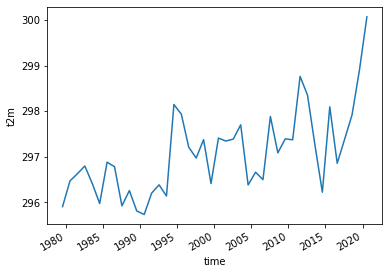

In [8]:
ERA5_California_events.plot()

Select the same domain for SEAS5 and extract the events.

In [9]:
SEAS5_California_events = (
    SEAS5_California['t2m'].sel(
        longitude = slice(-125,-100),    # Select the longitude
        latitude = slice(45,20)).
    where(ERA5_sd_anomaly.sel(time = '2020').squeeze('time') > 2).
    mean(['longitude', 'latitude']))

And here we store the data in the Data section so the rest of the analysis in R can be reproduced. 

In [10]:
SEAS5_California_events.to_dataframe().to_csv('Data/SEAS5_California_events.csv')
ERA5_California_events.to_dataframe().to_csv('Data/ERA5_California_events.csv')

C:\anaconda3\envs\unseen\lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Evaluate


<div class="alert alert-info">

Note

From here onward we use R and not python!
    
We switch to R since we believe R has a better functionality in extreme value statistics. 

</div>

In [1]:
setwd('../../..')
getwd()
SEAS5_California_events <- read.csv("Data/SEAS5_California_events.csv", stringsAsFactors=FALSE)
ERA5_California_events <- read.csv("Data/ERA5_California_events.csv", stringsAsFactors=FALSE)

## Convert Kelvin to Celsius
SEAS5_California_events$t2m <- SEAS5_California_events$t2m - 273.15
ERA5_California_events$t2m <- ERA5_California_events$t2m - 273.15

## Convert character time to Date format
ERA5_California_events$time <- lubridate::ymd(ERA5_California_events$time)
SEAS5_California_events$time <- lubridate::ymd(SEAS5_California_events$time)

[1] "C:/Users/Timo/OneDrive - Loughborough University/GitHub/UNSEEN-open"

*Is the UNSEEN ensemble realistic?* 

To answer this question, we perform three statistical tests: independence, model stability and model fidelity tests.  
These statistical tests are available through the [UNSEEN R package](https://github.com/timokelder/UNSEEN). 
See [evaluation](../3.Evaluate/3.Evaluate.ipynb) for more info.

In [2]:
require(UNSEEN)

Loading required package: UNSEEN



#### Timeseries
<a id='Timeseries'></a>

We plot the timeseries of SEAS5 (UNSEEN) and ERA5 (OBS) for the the Siberian Heatwave. 

You can call the documentation of the function with `?unseen_timeseries`

Warning message:
"Removed 4680 rows containing non-finite values (stat_boxplot)."


ERROR: Error in ggsave(timeseries, height = 5, width = 6, filename = "graphs/Calif_timeseries.png"): could not find function "ggsave"


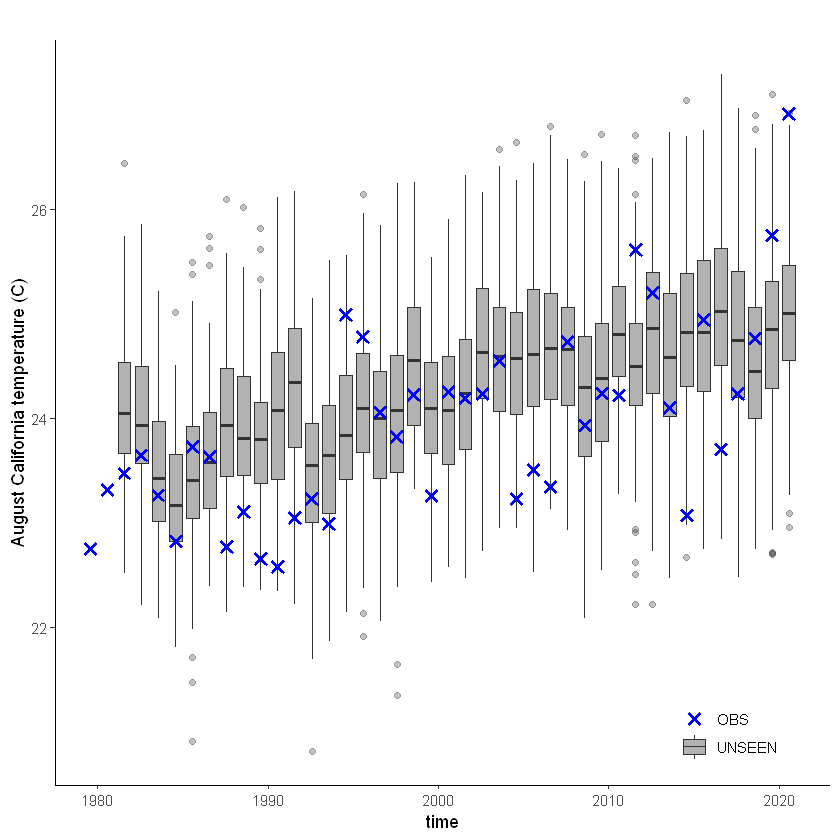

In [3]:
timeseries = unseen_timeseries(
    ensemble = SEAS5_California_events,
    obs = ERA5_California_events,
    ensemble_yname = "t2m",
    ensemble_xname = "time",
    obs_yname = "t2m",
    obs_xname = "time",
    ylab = "August California temperature (C)")


timeseries

ggsave(timeseries, height = 5, width = 6,   filename = "graphs/Calif_timeseries.png")


The timeseries consist of **hindcast (years 1982-2016)** and **archived forecasts (years 2017-2020)**. The datasets are slightly different: the hindcasts contains 25 members whereas operational forecasts contain 51 members, the native resolution is different and the dataset from which the forecasts are initialized is different. 

**For the evaluation of the UNSEEN ensemble we want to only use the SEAS5 hindcasts for a consistent dataset**. Note, 2017 is not used in either the hindcast nor the operational dataset, since it contains forecasts both initialized in 2016 (hindcast) and 2017 (forecast), see [retrieve](../1.Download/1.Retrieve.ipynb).
We split SEAS5 into hindcast and operational forecasts:

In [4]:
SEAS5_California_events_hindcast <- SEAS5_California_events[
    SEAS5_California_events$time < '2017-02-01' &
    SEAS5_California_events$number < 25,]

SEAS5_California_events_forecasts <- SEAS5_California_events[
    SEAS5_California_events$time > '2017-02-01',]

And we select the same years for ERA5. 

In [5]:
ERA5_California_events_hindcast <- ERA5_California_events[
    ERA5_California_events$time > '1981-02-01' &
    ERA5_California_events$time < '2017-02-01',]

Which results in the following timeseries:

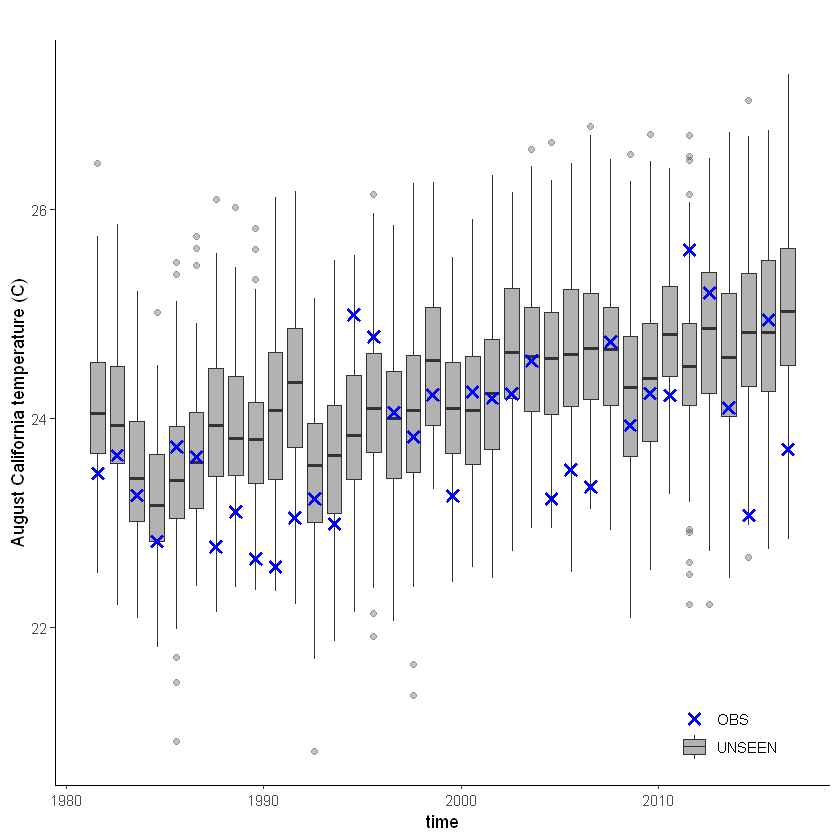

In [6]:
unseen_timeseries(
    ensemble = SEAS5_California_events_hindcast,
    obs = ERA5_California_events_hindcast,
    ensemble_yname = "t2m",
    ensemble_xname = "time",
    obs_yname = "t2m",
    obs_xname = "time",
    ylab = "August California temperature (C)")



#### Evaluation tests
With the hindcast dataset we evaluate the independence, stability and fidelity. Here, we plot the results for the fidelity test, for more detail on the other tests see the [evaluation section](../3.Evaluate/3.Evaluate.ipynb). 

The fidelity test shows us how consistent the model simulations of UNSEEN (SEAS5) are with the observed (ERA5). The UNSEEN dataset is much larger than the observed -- hence they cannot simply be compared. For example, what if we had faced a few more or a few less heatwaves purely by chance? 

This would influence the observed mean, but not so much influence the UNSEEN ensemble because of the large data sample. Therefore we express the UNSEEN ensemble as a range of plausible means, for data samples of the same length as the observed. We do the same for higher order [statistical moments](https://en.wikipedia.org/wiki/Moment_(mathematics)). 

ERROR: Error in ggsave(Eval, filename = "graphs/Calif_fidelity.png"): could not find function "ggsave"


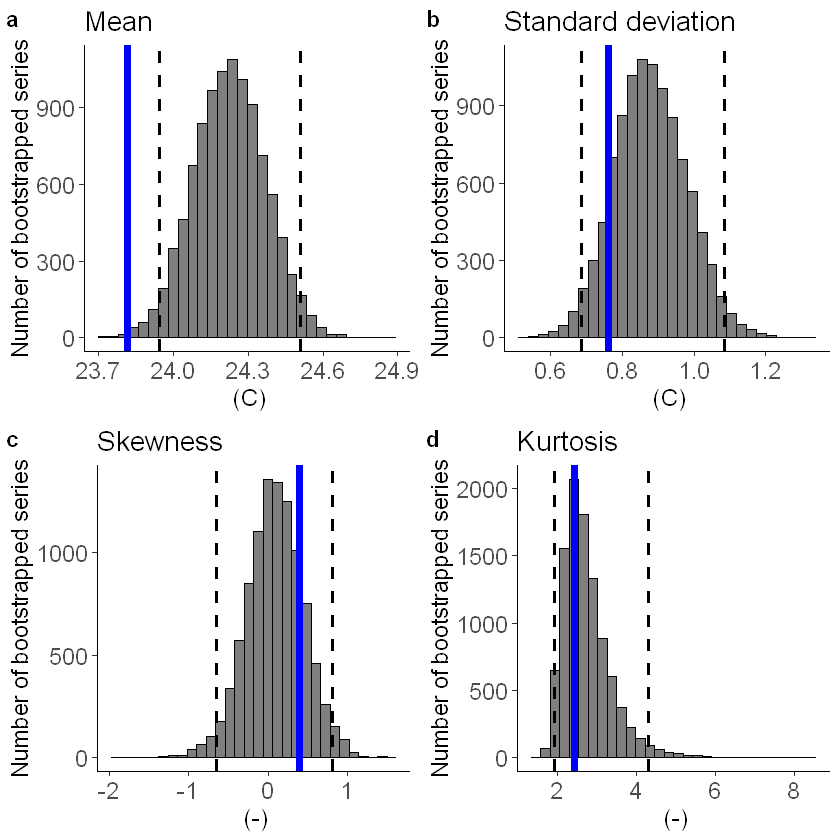

In [7]:
Eval = fidelity_test(
    obs = ERA5_California_events_hindcast$t2m,
    ensemble = SEAS5_California_events_hindcast$t2m,
    units = 'C',
    biascor = FALSE,
    fontsize = 14
)

Eval
ggsave(Eval, filename = "graphs/Calif_fidelity.png")


The fidelity test shows that the mean of the UNSEEN ensemble is too low compared to the observed -- the blue line falls outside of the model range in a. To correct for this low bias, we can apply an additive bias correction, which only corrects the mean of the simulations. 

Lets apply the additive biascor:

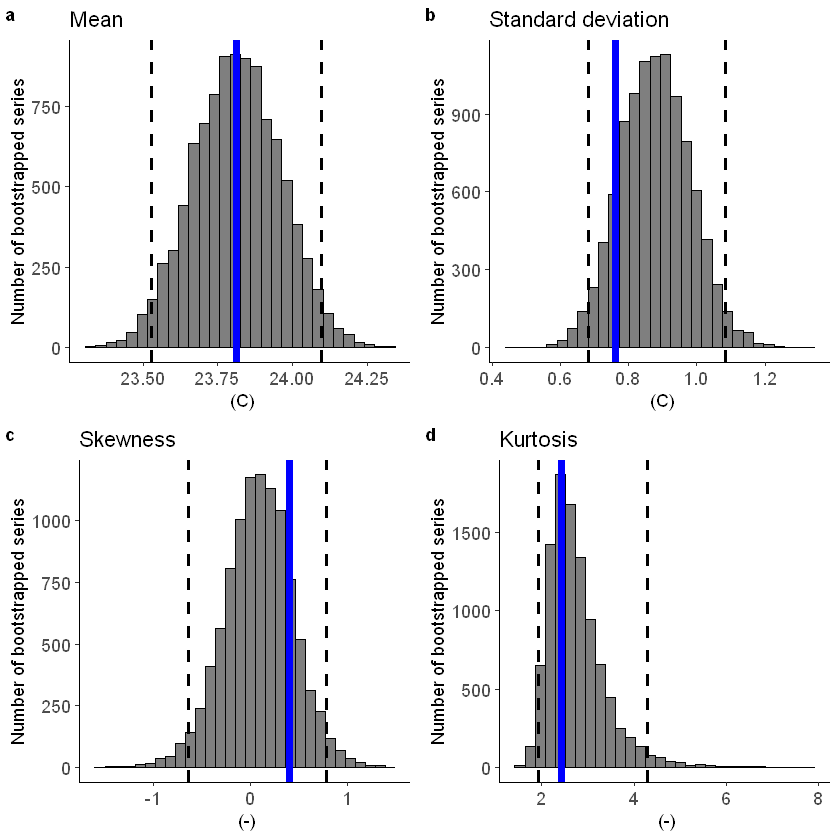

In [10]:
obs = ERA5_California_events_hindcast$t2m
ensemble = SEAS5_California_events_hindcast$t2m
ensemble_biascor = ensemble + (mean(obs) - mean(ensemble))

fidelity_test(
    obs = obs,
    ensemble = ensemble_biascor,
    units = 'C',
    biascor = FALSE
)

This shows us what we expected: the mean bias is corrected because the model simulations are shifted up (the blue line is still the same, the axis has just shifted along with the histogram), but the other statistical moments are the same. 

### Illustrate

In [8]:
source('src/evt_plot.r')

Loading required package: Lmoments

Loading required package: distillery


Attaching package: 'extRemes'


The following objects are masked from 'package:stats':

    qqnorm, qqplot




We apply extreme value theory to analyze the trend in 100-year temperature extremes. There are different extreme value distributions that can be used to fit to the data. First, we fit a stationary Gumbel and a GEV distribution (including shape parameter) to the observed extremes. Then we fit a nonstationary GEV distribution to the observed temperatures and show that this better describes the data because the p-value of 0.006 and 0.002 are very small (much below 0.05 based on 5% significance with the likelihood ratio test). 
<!-- How about nonstationarity?

Here I fit nonstationary distributions to the observed and to UNSEEN, and test whether those distributions fit better than stationary distributions. With a p value of 0.006, the nonstationary distribution is clearly a better fit.  -->

In [11]:
## Fit stationary distributions
fit_obs_Gumbel <- fevd(x = obs,
                    type = "Gumbel"
                   )
fit_obs_GEV <- fevd(x = obs,
                    type = "GEV"
                   )
## And the nonstationary distribution
fit_obs_GEV_nonstat <- fevd(x = obs,
                            type = "GEV",
                            location.fun = ~ c(1:36), ##Fitting the gev with a location and scale parameter linearly correlated to the covariate (years)
                            scale.fun = ~ c(1:36), 
                            use.phi = TRUE
                           )
#And test the fit
##1. Stationary Gumbel vs stationary GEV
lr.test(fit_obs_Gumbel, fit_obs_GEV_nonstat) 
##2. Stationary GEV vs Nonstationary GEV
lr.test(fit_obs_GEV, fit_obs_GEV_nonstat)


	Likelihood-ratio Test

data:  obsobs
Likelihood-ratio = 12.617, chi-square critical value = 7.8147, alpha =
0.0500, Degrees of Freedom = 3.0000, p-value = 0.005542
alternative hypothesis: greater



	Likelihood-ratio Test

data:  obsobs
Likelihood-ratio = 12.013, chi-square critical value = 5.9915, alpha =
0.0500, Degrees of Freedom = 2.0000, p-value = 0.002463
alternative hypothesis: greater


For the unseen ensemble this analysis is slightly more complicated since we need a covariate that has the same length as the ensemble:

In [12]:
#Create the ensemble covariate
year_vector = as.integer(format(SEAS5_California_events_hindcast$time, format="%Y"))
covariate_ens = year_vector - 1980 

# Fit the stationary distribution
fit_unseen_GEV <- fevd(x = ensemble_biascor,
                       type = 'GEV',
                       use.phi = TRUE)

fit_unseen_Gumbel <- fevd(x = ensemble_biascor,
                          type = 'Gumbel',
                          use.phi = TRUE)

# Fit the nonstationary distribution
fit_unseen_GEV_nonstat <- fevd(x = ensemble_biascor,
                               type = 'GEV',
                               location.fun = ~ covariate_ens, ##Fitting the gev with a location and scale parameter linearly correlated to the covariate (years)
                               scale.fun = ~ covariate_ens, 
                               use.phi = TRUE)

And the likelihood ratio test tells us that the nonstationary GEV distribution is the best fit, both p-values < 2.2e-16:

In [13]:
#And test the fit
##1. Stationary Gumbel vs stationary GEV
lr.test(fit_unseen_Gumbel,fit_unseen_GEV) 
##2. Stationary GEV vs Nonstationary GEV
lr.test(fit_unseen_GEV, fit_unseen_GEV_nonstat) 


	Likelihood-ratio Test

data:  ensemble_biascorensemble_biascor
Likelihood-ratio = 577.13, chi-square critical value = 3.8415, alpha =
0.0500, Degrees of Freedom = 1.0000, p-value < 2.2e-16
alternative hypothesis: greater



	Likelihood-ratio Test

data:  ensemble_biascorensemble_biascor
Likelihood-ratio = 956.98, chi-square critical value = 5.9915, alpha =
0.0500, Degrees of Freedom = 2.0000, p-value < 2.2e-16
alternative hypothesis: greater


We plot unseen trends in 100-year extremes. For more info on the methods see [this paper](https://doi.org/10.31223/osf.io/hyxeq)

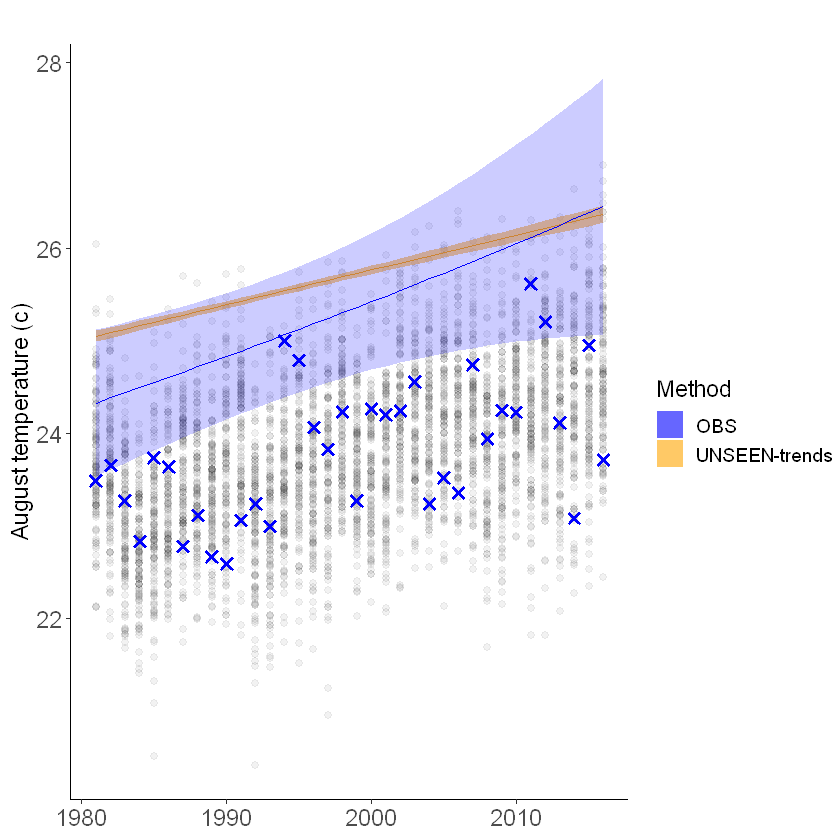

In [14]:
p1 <- unseen_trends1(ensemble = ensemble_biascor,
                     x_ens = year_vector,
                     x_obs = 1981:2016,
                     rp = 100,
                     obs = obs,
                     covariate_ens = covariate_ens,
                     covariate_obs = c(1:36),
                     GEV_type = 'GEV',
                     ylab = 'August temperature (c)')
p1

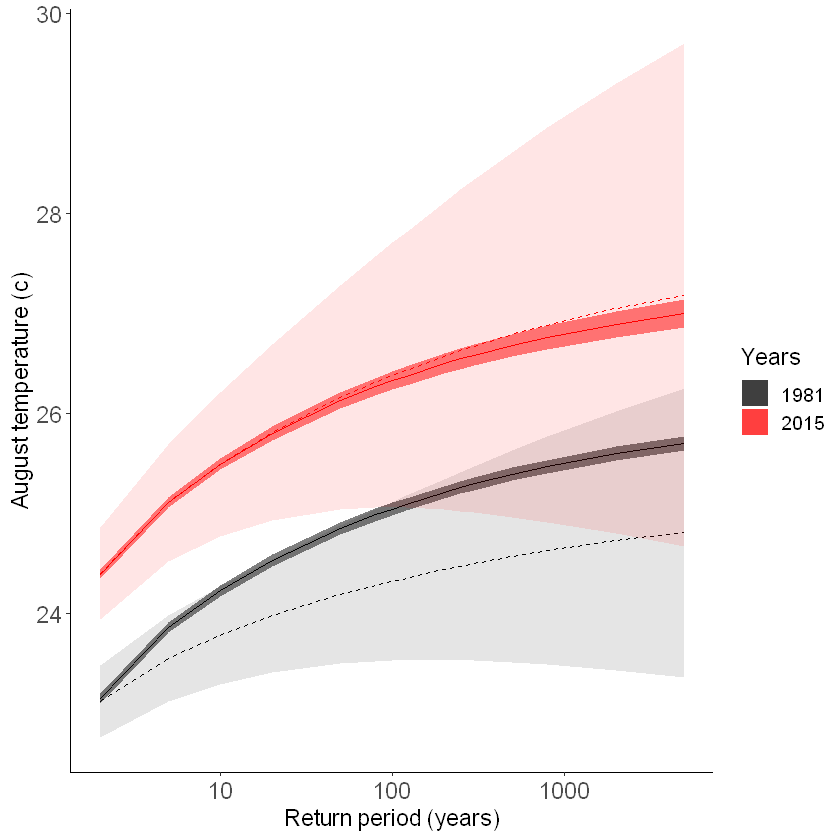

In [15]:
p2 <- unseen_trends2(ensemble = ensemble_biascor,
                    obs = obs,
                    covariate_ens = covariate_ens,
                    covariate_obs = c(1:36), 
                    GEV_type = 'GEV', 
                    ylab = 'August temperature (c)')

p2

**Applications:**

We have seen the worst fire season over California this year. Such fires are likely part of a chain of impacts, from droughts to heatwaves to fires, with feedbacks between them. Here we assess August temperatures and show that the 2020 August average temperature was very anomalous. We furthermore use SEAS5 forecasts to analyze the trend in rare extremes. Evaluation metrics show that the model simulations have a high bias, which we correct for using an additive bias correction. UNSEEN trend analysis shows a clear trend over time, both in the model and in the observed temperatures. Based on this analysis, temperature extremes that you would expect to occur once in 100 years in 1981 might occur once in 10 years in 2015 -- and even more frequently now!

**Note**

Our analysis shows the results of a *linear* trend analysis of August temperature averages over 1981-2015. Other time windows, different trends than linear, and spatial domains could (should?) be investigated, as well as drought estimates in addition to temperature extremes.  